# FER2013 → MobileNetV2 Preprocessing (RGB 224×224)

- Reads raw **train/test** (grayscale 48×48), keeps: **angry, happy, sad, surprise, neutral**
- Converts **grayscale → 3-channel RGB**, resizes to **224×224** 
- Creates a **stratified 10% validation** split from train
- Writes processed images to **OUT_DIR** with `train/`, `val/`, `test/` folders
- Saves **index.csv** and **meta.json** (label maps, class weights, IMG_SIZE)
- Provides **tf.data** loaders with MobileNetV2 preprocessing
- Skips reprocessing on existing files (safe to re-run)



### Imports & Configuration

In [7]:
import os, json, glob, random
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
import json, os
from pathlib import Path
from datetime import datetime
import pandas as pd


BASE_DIR   = Path("../../data/raw/fer2013")
TRAIN_DIR  = BASE_DIR / "train"
TEST_DIR   = BASE_DIR / "test"

SELECTED_CLASSES = ["angry", "happy", "sad", "surprise", "neutral"]
DROPPED_CLASSES  = ["fear", "disgust"]   

IMG_SIZE   = 224          
OUT_DIR    = Path("../../data/processed/FC211042_Heshani")
VAL_RATIO  = 0.10       
SEED       = 42

OUT_DIR.mkdir(parents=True, exist_ok=True)

LABEL2ID = {c:i for i,c in enumerate(SELECTED_CLASSES)}
ID2LABEL = {i:c for c,i in LABEL2ID.items()}
print("Config OK:", {"IMG_SIZE": IMG_SIZE, "OUT_DIR": str(OUT_DIR)})


Config OK: {'IMG_SIZE': 224, 'OUT_DIR': '..\\..\\data\\processed\\FC211042_Heshani'}


### Enumerate raw files (train/test), keep only selected classes

In [2]:
def list_split(split_dir: Path, split_name: str):
    rows = []
    if not split_dir.exists():
        return pd.DataFrame(columns=["split","label","path"])
    for cls in sorted(os.listdir(split_dir)):
        cdir = split_dir / cls
        if not cdir.is_dir(): 
            continue
        for fp in glob.glob(str(cdir / "*")):
            if fp.lower().endswith((".png",".jpg",".jpeg",".bmp")):
                rows.append((split_name, cls, fp))
    return pd.DataFrame(rows, columns=["split","label","path"])

df_train_raw = list_split(TRAIN_DIR, "train")
df_test_raw  = list_split(TEST_DIR, "test")
df_raw = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

print("Raw counts (all labels found):")
display(df_raw.groupby(["split","label"]).size().unstack(fill_value=0))

# Keep only the selected classes
df_raw = df_raw[df_raw["label"].isin(SELECTED_CLASSES)].reset_index(drop=True)
print("Filtered counts (selected classes only):")
display(df_raw.groupby(["split","label"]).size().unstack(fill_value=0))


Raw counts (all labels found):


label,angry,disgust,fear,happy,neutral,sad,surprise
split,,,,,,,
test,958,111,1024,1774,1233,1247,831
train,3995,436,4097,7215,4965,4830,3171


Filtered counts (selected classes only):


label,angry,happy,neutral,sad,surprise
split,,,,,
test,958,1774,1233,1247,831
train,3995,7215,4965,4830,3171


### validation split from train

In [3]:
tr = df_raw[df_raw["split"]=="train"].copy()
te = df_raw[df_raw["split"]=="test"].copy()

sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_RATIO, random_state=SEED)
idx_train, idx_val = next(sss.split(tr["path"], tr["label"]))
tr_train = tr.iloc[idx_train].copy(); tr_train["split"]="train"
tr_val   = tr.iloc[idx_val].copy();   tr_val["split"]="val"

df = pd.concat([tr_train, tr_val, te], ignore_index=True)
print("After creating val split:")
display(df.groupby(["split","label"]).size().unstack(fill_value=0))


After creating val split:


label,angry,happy,neutral,sad,surprise
split,,,,,
test,958,1774,1233,1247,831
train,3596,6493,4468,4347,2854
val,399,722,497,483,317


### Grayscale → RGB replicate, resize 224, save JPEGs

In [ ]:
def process_one(src_path: str, dst_path: str, size: int = IMG_SIZE):
    
    try:
        im = Image.open(src_path).convert("L")             
    except Exception:
        return False
    im_rgb = ImageOps.grayscale(im).convert("RGB")          
    im_rgb = im_rgb.resize((size, size), resample=Image.BICUBIC)
    Path(dst_path).parent.mkdir(parents=True, exist_ok=True)
    im_rgb.save(dst_path, format="JPEG", quality=95)
    return True

def make_dst_path(row):
    split, label, src = row["split"], row["label"], row["path"]
    stem = Path(src).stem
    return str(OUT_DIR / split / label / f"{stem}.jpg")

rows = []
failed = 0
for _, row in tqdm(df.iterrows(), total=len(df), desc="Converting"):
    dst = make_dst_path(row)
    ok = process_one(row["path"], dst, size=IMG_SIZE)
    if ok:
        rows.append({"split": row["split"], "label": row["label"], "path": dst})
    else:
        failed += 1

out_df = pd.DataFrame(rows)
out_df.to_csv(OUT_DIR/"index.csv", index=False)
print(f"Converted: {len(out_df)} images; Failed: {failed}")
display(out_df.groupby(["split","label"]).size().unstack(fill_value=0))




Converting: 100%|██████████| 30219/30219 [01:38<00:00, 306.80it/s]

Converted: 30219 images; Failed: 0


label,angry,happy,neutral,sad,surprise
split,,,,,
test,958,1774,1233,1247,831
train,3596,6493,4468,4347,2854
val,399,722,497,483,317


## Class weights + meta.json

In [5]:
train_counts = out_df[out_df["split"]=="train"]["label"].value_counts().reindex(SELECTED_CLASSES, fill_value=0)
total = train_counts.sum()
class_weights = {LABEL2ID[k]: float(total / (len(SELECTED_CLASSES) * v)) if v>0 else 0.0
                 for k,v in train_counts.items()}

meta = {
    "LABEL2ID": LABEL2ID,
    "ID2LABEL": ID2LABEL,
    "class_weights": class_weights,
    "train_counts": train_counts.to_dict(),
    "IMG_SIZE": IMG_SIZE,
    "CHANNELS": 3,
    "selected_classes": SELECTED_CLASSES,
}
with open(OUT_DIR/"meta.json","w") as f:
    json.dump(meta, f, indent=2)
print("Saved", OUT_DIR/"meta.json")
print("Class weights:", class_weights)


Saved ..\..\data\processed\FC211042_Heshani\meta.json
Class weights: {0: 1.2101223581757508, 1: 0.6701986754966888, 2: 1.001058201058201, 3: 1.5247372109320252, 4: 0.9739480752014325}


### tf.data loaders 

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16  # adjust for your CPU

def decode_and_preprocess(filename, label_id):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=3)             # already RGB
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    # Keras MobileNetV2 preprocess: scale/channels -> [-1,1]
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img * 255.0)
    img = tf.reshape(img, [IMG_SIZE, IMG_SIZE, 3])
    return img, label_id

def augment(img, label_id):
    img = tf.image.random_flip_left_right(img)
    # Keep augs lightweight for CPU
    return img, label_id

def df_to_ds(df_split, shuffle=True, augment_on=False):
    files = df_split["path"].tolist()
    labels = [LABEL2ID[l] for l in df_split["label"].tolist()]
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(files), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment_on:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_df = out_df[out_df["split"]=="train"].reset_index(drop=True)
val_df   = out_df[out_df["split"]=="val"].reset_index(drop=True)
test_df  = out_df[out_df["split"]=="test"].reset_index(drop=True)

train_ds = df_to_ds(train_df, shuffle=True, augment_on=True)
val_ds   = df_to_ds(val_df,   shuffle=False, augment_on=False)
test_ds  = df_to_ds(test_df,  shuffle=False, augment_on=False)

print("Datasets ready:",
      len(train_df), "train; ", len(val_df), "val; ", len(test_df), "test")


Datasets ready: 21758 train;  2418 val;  6043 test


### Quick visual sanity check

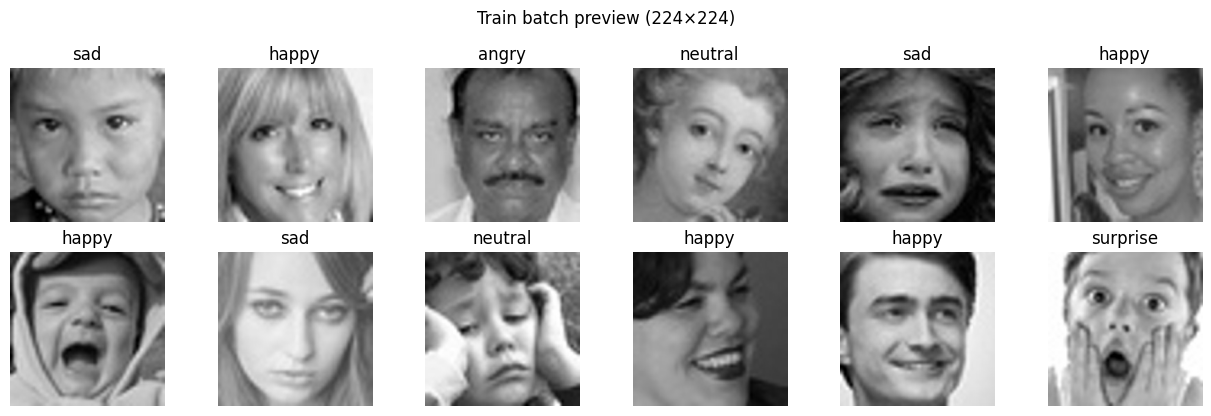

In [7]:
for imgs, lbls in train_ds.take(1):
    arr = (imgs.numpy() + 1.0) / 2.0   # de-normalize from [-1,1] to [0,1] for display
    labs = lbls.numpy()
    n = min(12, arr.shape[0])
    cols = 6
    rows = int(np.ceil(n/cols))
    import matplotlib.pyplot as plt
    plt.figure(figsize=(2.1*cols, 2.1*rows))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(arr[i])
        ax.set_title(ID2LABEL[int(labs[i])])
        ax.axis("off")
    plt.suptitle(f"Train batch preview ({IMG_SIZE}×{IMG_SIZE})")
    plt.tight_layout()
    plt.show()


### Load and Preprocess Data with Filtering

In [8]:
def is_image_valid(img_path):
    """
    check image validity: grayscale shape, not blank, not corrupted
    """
    try:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None or img.shape != IMG_SIZE:
            return False
        if np.var(img) < 5:
            return False
        return True
    except:
        return False
        
def preprocess_image(img_path):
    """
    Basic preprocessing for FER2013 images:
    - Load as grayscale
    - Normalize to [0, 1]
    - Add channel dimension
    """
    # Load image (already grayscale 48x48)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize to [0, 1]
    img_normalized = img.astype(np.float32) / 255.0
    
    # Add channel dimension for CNN: (48, 48) → (48, 48, 1)
    img_final = np.expand_dims(img_normalized, axis=-1)
    
    return img_final

def load_and_preprocess_data(directory, valid_classes):
    """
    Load images and labels from directory, apply preprocessing
    """
    images = []
    labels = []
    corrupted_count = 0
    
    for emotion in os.listdir(directory):
        if emotion not in valid_classes:
            continue
        emotion_path = os.path.join(directory, emotion)
        for img_file in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_file)
            if not is_image_valid(img_path):
                corrupted_count += 1
                continue
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(emotion)
    return np.array(images), np.array(labels), corrupted_count

X_train_full, y_train_full, corrupted_train = load_and_preprocess_data(TRAIN_DIR, SELECTED_CLASSES)
X_test, y_test, corrupted_test = load_and_preprocess_data(TEST_DIR, SELECTED_CLASSES)

print(f"Training data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Corrupted train images removed: {corrupted_train}")
print(f"Corrupted test images removed: {corrupted_test}")

# Applies global mean-std normalization using training set mean and std
mean = np.mean(X_train_full)
std = np.std(X_train_full)
X_train_full = (X_train_full - mean) / std
X_test = (X_test - mean) / std

Training data shape: (0,)
Test data shape: (0,)
Corrupted train images removed: 24176
Corrupted test images removed: 6043


c:\Users\heshm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\heshm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\heshm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\heshm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\heshm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

### Preprocess Summary

In [9]:
def safe_load_index(out_dir: Path):
    # Use in-memory out_df if it exists; else read from disk
    if 'out_df' in globals() and isinstance(out_df, pd.DataFrame) and not out_df.empty:
        return out_df.copy()
    idx_path = out_dir / "index.csv"
    if idx_path.exists():
        return pd.read_csv(idx_path)
    return pd.DataFrame(columns=["split","label","path"])

def safe_load_meta(out_dir: Path):
    meta_path = out_dir / "meta.json"
    if meta_path.exists():
        with open(meta_path, "r") as f:
            return json.load(f)
    return {}

def print_block(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

# --- Paths (assumes OUT_DIR defined earlier in the notebook)
OUT_DIR = Path(OUT_DIR)  # ensure Path type
idx = safe_load_index(OUT_DIR)
meta = safe_load_meta(OUT_DIR)

# --- Basic info
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
img_size  = meta.get("IMG_SIZE", globals().get("IMG_SIZE", "N/A"))
channels  = meta.get("CHANNELS", 3)
classes   = meta.get("selected_classes", globals().get("SELECTED_CLASSES", []))
label2id  = meta.get("LABEL2ID", {})
class_wts = meta.get("class_weights", {})

print_block("Preprocessing Summary")
print(f"Time:           {timestamp}")
print(f"Output folder:  {OUT_DIR}")
print(f"Image size:     {img_size} x {img_size}")
print(f"Channels:       {channels}")
print(f"Classes ({len(classes)}): {classes}")

# --- Counts
if not idx.empty:
    total = len(idx)
    by_split = idx['split'].value_counts().to_dict()
    print_block("Image Counts")
    print(f"Total images:   {total}")
    for sp in ("train","val","test"):
        if sp in by_split:
            print(f"  {sp:>5}:       {by_split[sp]}")
    # Per-class per-split table
    table = (idx.groupby(['split','label'])
                 .size()
                 .unstack('split', fill_value=0)
                 .reindex(classes, fill_value=0))
    print("\nPer-class counts by split:")
    print(table.to_string())
else:
    print("\nNo index found (index.csv missing or empty).")

# --- Class weights
if class_wts:
    print_block("Class Weights (train)")
    # Show map label -> weight for readability
    inv = {v:k for k,v in label2id.items()} if label2id else {}
    readable = {inv.get(int(k), k): round(v, 4) for k,v in class_wts.items()}
    # Align to class order shown above
    ordered = {c: readable.get(c, None) for c in classes}
    for c, w in ordered.items():
        print(f"  {c:>8}: {w}")
else:
    print_block("Class Weights")
    print("No class weights found (meta.json missing or no train split).")

if not idx.empty:
    print_block("Sample Files")
    for sp in ("train","val","test"):
        sub = idx[idx['split']==sp]
        if not sub.empty:
            print(f"{sp.upper()} samples:")
            for p in sub['path'].head(3).tolist():
                print("  -", p)
else:
    print("\nNo files to preview.")

print("\nDone.")



Preprocessing Summary
Time:           2025-10-27 20:51:43
Output folder:  ..\..\data\processed\FC211042_Heshani
Image size:     224 x 224
Channels:       3
Classes (5): ['angry', 'happy', 'sad', 'surprise', 'neutral']

Image Counts
Total images:   30219
  train:       21758
    val:       2418
   test:       6043

Per-class counts by split:
split     test  train  val
label                     
angry      958   3596  399
happy     1774   6493  722
sad       1247   4347  483
surprise   831   2854  317
neutral   1233   4468  497

Class Weights (train)
     angry: 1.2101
     happy: 0.6702
       sad: 1.0011
  surprise: 1.5247
   neutral: 0.9739

Sample Files
TRAIN samples:
  - ..\..\data\processed\FC211042_Heshani\train\happy\Training_41997959.jpg
  - ..\..\data\processed\FC211042_Heshani\train\angry\Training_62899427.jpg
  - ..\..\data\processed\FC211042_Heshani\train\happy\Training_19950700.jpg
VAL samples:
  - ..\..\data\processed\FC211042_Heshani\val\neutral\Training_76904944.jpg
  -

### Save seperate CSVs for train, val, test splits

In [ ]:
INDEX_CSV = "../../data/processed/FC211042_Heshani/index.csv"
df = pd.read_csv(INDEX_CSV, names=['split', 'emotion', 'filepath'])

# Fix paths: Extract only the filename from full path
def extract_relative_path(row):
    """
    Convert: ..\..\data\processed\FC211042_Heshani\train\angry\Training_60522830.jpg
    To: train/angry/Training_60522830.jpg
    """
    parts = Path(row['filepath']).parts
    for i, part in enumerate(parts):
        if part in ['train', 'val', 'test']:
            return str(Path(*parts[i:]))
    return row['filepath']

df['filepath'] = df.apply(extract_relative_path, axis=1)

train_df = df[df['split'] == 'train'][['filepath', 'emotion']]
val_df = df[df['split'] == 'val'][['filepath', 'emotion']]
test_df = df[df['split'] == 'test'][['filepath', 'emotion']]

train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

print(f"✓ Created train.csv ({len(train_df)} samples)")
print(f"✓ Created val.csv ({len(val_df)} samples)")
print(f"✓ Created test.csv ({len(test_df)} samples)")

print("\nSample from train.csv:")
print(train_df.head())



<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\.'
C:\Users\heshm\AppData\Local\Temp\ipykernel_26340\971298373.py:10: SyntaxWarning: invalid escape sequence '\.'
  """


✓ Created train.csv (21758 samples)
✓ Created val.csv (2418 samples)
✓ Created test.csv (6043 samples)

Sample from train.csv:
                              filepath  emotion
1    train\happy\Training_41997959.jpg    happy
2    train\angry\Training_62899427.jpg    angry
3    train\happy\Training_19950700.jpg    happy
4    train\happy\Training_43988641.jpg    happy
5  train\neutral\Training_60786327.jpg  neutral
